In [1]:
#IMPORTS

from typing import Tuple, Dict, Any, List
import os
from tkinter import Tk, filedialog, simpledialog, messagebox, Button, Label
import tkinter as tk
from tkinter.filedialog import askopenfilenames, askdirectory, asksaveasfilename, askopenfilename
from tkinter.simpledialog import askinteger

import geopandas as gpd
import ipywidgets as widgets
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import numpy as np
import pandas as pd
import panel as pn
from rasterio.enums import Resampling
from rasterio.transform import from_bounds
from rasterio.features import rasterize
import rasterio
from rasterio.warp import reproject, Resampling
from shapely.geometry import box
import xarray as xr
import seaborn as sns

from IPython.display import display

from joblib import Parallel, delayed

from scipy.ndimage import distance_transform_edt
from shapely.geometry import LineString



In [ ]:
#CALCULATE GRID SIZE (from mask short edge)

# Function to compute grid size based on the mask file
def compute_grid_size(geojson_file: str, short_edge_cells: int = 20) -> Tuple[int, int]:
    # Read the GeoJSON file using GeoPandas
    gdf = gpd.read_file(geojson_file)
    
    # Get the bounding box of the masking region
    minx, miny, maxx, maxy = gdf.total_bounds
    
    # Calculate width and height of the bounding box
    width = maxx - minx
    height = maxy - miny

    # Determine which is the short and long edge
    if width < height:
        short_edge = width
        long_edge = height
        orientation = 'portrait'
    else:
        short_edge = height
        long_edge = width
        orientation = 'landscape'

    # Compute the aspect ratio
    aspect_ratio = long_edge / short_edge

    # Compute the number of cells for the long edge
    long_edge_cells = int(short_edge_cells * aspect_ratio)

    # Determine the grid size based on the orientation
    if orientation == 'portrait':
        grid_size = (short_edge_cells, long_edge_cells)
    else:
        grid_size = (long_edge_cells, short_edge_cells)

    return grid_size

# Prompt the user for the short_edge_cells value using tkinter
root = Tk()
root.withdraw()  # Hide the root window
root.attributes("-topmost", True)  # Ensure it is on top


# Ask the user for the short edge size
short_edge_cells = simpledialog.askinteger("Input", "Enter the number of cells for the short edge:", minvalue=1)

root.destroy()  # Close the tkinter root window

if short_edge_cells is None:
    raise ValueError("You must enter a valid number for the short edge size.")

# Prompt the user to select the mask file
def get_mask_file():
    root = Tk()
    root.withdraw()  # Hide the root window
    root.attributes("-topmost", True)  # Bring the file dialog to the front
    file_path = askopenfilename(
        title="Select a Mask GeoJSON File",
        filetypes=[("GeoJSON files", "*.geojson"), ("All files", "*.*")]
    )
    root.destroy()  # Close the tkinter root window
    return file_path

# Set the mask file path
mask_file = get_mask_file()

# Compute grid size using the mask file
grid_size = compute_grid_size(mask_file, short_edge_cells=short_edge_cells)[::-1]
print(f"Calculated grid size: {grid_size}")


In [ ]:
#SELECT VECTOR FILES

# Function to interactively select files
def select_geojson_files():
    # Create a Tkinter root window (hidden)
    root = Tk()
    root.withdraw()  # Hide the main window
    root.attributes("-topmost", True)  # Bring the dialog to the front

    # Open the file selection dialog
    geojson_files = filedialog.askopenfilenames(
        title="Select GeoJSON Files",
        filetypes=[("GeoJSON files", "*.geojson"), ("All files", "*.*")]
    )
    
    root.destroy()  # Close the root window after selection
    return list(geojson_files)  # Convert tuple to list and return

# Use the function to select files
geojson_files = select_geojson_files()

# Print the selected files for verification
print(f"Selected GeoJSON files: {geojson_files}")

#SELECT VECTOR FILE LAYERS
vector_features_to_process = []

def select_columns(geojson_file):
    """Function to display column selection widgets for a given GeoJSON file."""
    # Read the GeoJSON file using GeoPandas
    gdf = gpd.read_file(geojson_file)
    
    # Get the list of columns
    columns = gdf.columns.tolist()
    
    # Create a multiple selection widget for columns
    selection = widgets.SelectMultiple(
        options=columns,
        description=f'Select columns for {os.path.basename(geojson_file)}:',
        rows=10
    )
    
    # Display the widget and button
    display(selection)

    # Define button click event
    def on_button_click(b):
        # For each selected column, create a tuple of (geojson_file, column_name)
        selected_columns = [(geojson_file, col) for col in selection.value]
        vector_features_to_process.extend(selected_columns)
        print(f'Selected columns from {geojson_file}: {selected_columns}')
    
    # Create and display button
    button = widgets.Button(description="Submit Selection")
    button.on_click(on_button_click)
    display(button)

# Iterate through each GeoJSON file and let the user select columns
for file in geojson_files:
    select_columns(file)

In [ ]:
# SELECT, BUFFER/RASTERIZE POINTS OF INTEREST

# Function to ask user for multiple input GeoJSON files
def get_input_files():
    root = Tk()
    root.withdraw()  # Hide the root window
    root.attributes("-topmost", True)  # Bring the dialog to the front
    file_paths = askopenfilenames(
        title="Select POI GeoJSON Files",
        filetypes=[("GeoJSON files", "*.geojson"), ("All files", "*.*")]
    )
    root.destroy()  # Close the Tkinter root window
    return file_paths

# Function to ask user for buffer size
def get_buffer_size():
    root = Tk()
    root.withdraw()  # Hide the root window
    root.attributes("-topmost", True)  # Bring the dialog to the front
    buffer_size = askinteger("Input", "Enter the buffer size in meters:", minvalue=1)
    root.destroy()  # Close the Tkinter root window
    return buffer_size

# Function to ask the user if they want to merge the files with Yes/No buttons
def ask_merge_or_separate():
    root = Tk()
    root.withdraw()  # Hide the root window
    root.attributes("-topmost", True)  # Bring the dialog to the front
    response = messagebox.askyesno("Merge Targets", "Would you like to merge the target files?")
    root.destroy()
    return response  # Returns True if 'Yes' is clicked, else False

# Function to buffer and rasterize a single POI file
def buffer_and_rasterize(POI_file, POI_buffer_size, grid_size):
    # Read the GeoJSON file
    POI_df = gpd.read_file(POI_file)
    
    # Reproject to a CRS that allows buffering (e.g., UTM)
    POI_df_projected = POI_df.to_crs("EPSG:3857")  # UTM or other projected CRS for buffering
    
    # Buffer the points by the specified buffer size (in meters)
    POI_df_projected['geometry'] = POI_df_projected.geometry.buffer(POI_buffer_size)
    
    # Create the transform using the bounds and grid size
    bounds = POI_df_projected.total_bounds
    POI_transform = from_bounds(bounds[0], bounds[1], bounds[2], bounds[3], grid_size[1], grid_size[0])

    # Rasterize the buffered points, setting the value of points to 1, others to 0
    POI_geometry_generator = ((geom, 1) for geom in POI_df_projected.geometry)
    POI_data = rasterize(shapes=POI_geometry_generator, out_shape=grid_size, fill=0, transform=POI_transform).astype('float32')

    # Reshape the data into a 3D NumPy array with one layer for the data
    POI_data_3D = np.expand_dims(POI_data, axis=0)  # Expands the data to have a layer dimension at the front
    
    # Return the 3D array
    return POI_data_3D

# Function to process multiple POI files
def process_multiple_POIs(grid_size):
    # Get multiple POI files from user input
    POI_files = get_input_files()
    
    # Initialize an empty list to store the combined POI data
    combined_POI_data = []
    
    # Initialize a list to store the POI layer names
    POI_layer_names = []
    
    # Ask the user if they want to merge the files or keep them separate
    merge_targets = ask_merge_or_separate()
    
    if merge_targets:
        # If merging, initialize an empty array for merged data
        merged_POI_data = np.zeros(grid_size)
        for POI_file in POI_files:
            # Ask for buffer size for each POI file
            POI_buffer_size = get_buffer_size()
            
            # Buffer and rasterize the POI file
            POI_data = buffer_and_rasterize(POI_file, POI_buffer_size, grid_size)
            
            # Add the rasterized data to the merged POI data (values of 1 take precedence)
            merged_POI_data = np.maximum(merged_POI_data, POI_data[0])  # Use max to keep points where there's overlap
        
        # After merging, expand the merged data to have a layer dimension and append to the combined list
        combined_POI_data.append(np.expand_dims(merged_POI_data, axis=0))
        POI_layer_names.append("TARGETS")  # Single layer name for merged data
    else:
        # If not merging, process each file separately
        for idx, POI_file in enumerate(POI_files, start=1):
            # Ask for buffer size for each POI file
            POI_buffer_size = get_buffer_size()
            
            # Buffer and rasterize the POI file
            POI_data = buffer_and_rasterize(POI_file, POI_buffer_size, grid_size)
            
            # Append the POI data to the combined list
            combined_POI_data.append(POI_data)
            
            # Get the filename without extension and use it in the layer name
            POI_filename = os.path.splitext(os.path.basename(POI_file))[0]
            POI_layer_names.append(f"TARGET_{POI_filename}")
    
    # Concatenate the list of POI layers along the first axis (layer axis)
    combined_POI_data_3D = np.concatenate(combined_POI_data, axis=0)
    
    # Return the combined data and layer names
    return combined_POI_data_3D, POI_layer_names


POI_data, POI_layer_names = process_multiple_POIs(grid_size)

# Check the shape of the combined result
print(f"Combined POI_data shape: {POI_data.shape}")
print(f"POI layer names: {POI_layer_names}")


In [25]:
#POLYGON VECTOR PROCESSING FUNCTIONS

def process_cell(idx, cell, gdf, sindex, feature_column, category_to_int):
    i, j = divmod(idx, grid_size[1])

    # Use the spatial index to find potential intersecting polygons
    possible_matches_index = list(sindex.intersection(cell.bounds))
    if not possible_matches_index:
        return i, j, np.nan  # Return NaN if no polygon is found

    possible_matches = gdf.iloc[possible_matches_index]
    if possible_matches.empty:
        return i, j, np.nan  # Return NaN if no polygon is found

    # For polygons, find intersections
    intersections = possible_matches.geometry.intersection(cell)
    valid_intersections = intersections[intersections.area > 0]

    if valid_intersections.empty:
        return i, j, np.nan

    if len(valid_intersections) > 5:
        areas_per_category = {}
        for idx, intersection in enumerate(valid_intersections):
            if not intersection.is_empty:
                category = possible_matches.iloc[idx][feature_column]
                # Use the raw category (no file name prefix)
                if category not in areas_per_category:
                    areas_per_category[category] = 0
                areas_per_category[category] += intersection.area

        if areas_per_category:
            max_category = max(areas_per_category, key=areas_per_category.get)
            return i, j, category_to_int[max_category]
        else:
            return i, j, np.nan
    else:
        largest_intersection_idx = valid_intersections.area.idxmax()
        category = possible_matches.loc[largest_intersection_idx, feature_column]
        # Use raw category here as well
        return i, j, category_to_int[category]


# Function to process each feature column
def process_feature_column(geojson_file, feature_column, grid_size, target_crs, x, y):
    gdf = gpd.read_file(geojson_file)
    print(f"Processing feature column: {feature_column} from file: {geojson_file}")

    gdf = gdf.to_crs(target_crs)
    if gdf.empty:
        print(f"GeoDataFrame for {geojson_file} is empty after reprojecting. Skipping column: {feature_column}")
        return None

    # Remove filename from category_to_int key and only use field names for values
    unique_categories = gdf[feature_column].unique()
    category_to_int = {cat: i for i, cat in enumerate(unique_categories)}

    grid = np.full(grid_size, np.nan)  # Create an empty grid filled with NaN
    sindex = gdf.sindex

    cells = [box(x[j], y[i], x[j + 1], y[i + 1])
             for i in range(grid_size[0])
             for j in range(grid_size[1])]

    results = Parallel(n_jobs=-1)(delayed(process_cell)(
        idx, cell, gdf, sindex, feature_column, category_to_int
    ) for idx, cell in enumerate(cells))

    if not results:
        print(f"No results were generated for feature column: {feature_column} from file: {geojson_file}")
        return None

    for i, j, value in results:
        grid[i, j] = value

    # Flip the grid vertically (along Y-axis)
    grid_flipped = np.flipud(grid)

    # Strip '.geojson' from the file name to clean up field names
    filename_cleaned = os.path.basename(geojson_file).replace('.geojson', '')
    return (f"{filename_cleaned}_{feature_column}", grid_flipped, category_to_int)


# Batch processing function
def geojson_to_numpy_grid_3d_batch(
    grid_size: Tuple[int, int],  # Grid size for the output array
    geojson_files: List[str],  # List of GeoJSON files
    features_to_process: List[Tuple[str, str]],  # List of (file, feature) tuples to process
    target_crs: str = "EPSG:3857"  # Web Mercator projection
) -> Tuple[np.ndarray, Dict[str, np.ndarray], Dict[str, Dict[Any, int]], List[Dict[str, Any]]]:
    all_feature_grids = {}
    all_feature_mappings = {}  # Initialize all_feature_mappings to track the category mappings
    geospatial_info_list = []

    results = []

    # Process each file and its corresponding features
    for geojson_file in geojson_files:
        # Get the filename without extension for prefixing the field names
        filename_prefix = os.path.basename(geojson_file).replace('.geojson', '').replace('.json', '')

        # Read the GeoJSON file to get the total bounds
        gdf = gpd.read_file(geojson_file)
        gdf = gdf.to_crs(target_crs)
        minx, miny, maxx, maxy = gdf.total_bounds

        x = np.linspace(minx, maxx, grid_size[1] + 1)
        y = np.linspace(miny, maxy, grid_size[0] + 1)

        # Extract relevant features for this file
        file_features = [feature for file, feature in features_to_process if file == geojson_file]

        # Store geospatial information for each file
        geospatial_info = {
            'transform': (minx, miny, maxx, maxy),
            'crs': target_crs,
            'file_name': filename_prefix
        }
        geospatial_info_list.append(geospatial_info)

        # Use joblib to parallelize the processing of each feature column
        results.extend(Parallel(n_jobs=-1)(delayed(process_feature_column)(
            geojson_file, feature_column, grid_size, target_crs, x, y
        ) for feature_column in file_features))

    for feature_name, grid, category_to_int in results:
        all_feature_grids[feature_name] = grid
        all_feature_mappings[feature_name] = category_to_int  # Store category mappings for each feature

    grid_3d = np.stack(list(all_feature_grids.values()), axis=0)

    return grid_3d, all_feature_grids, all_feature_mappings, geospatial_info_list


In [26]:
#LINE VECTOR PROCESSING FUNCTIONS

# Define function to calculate distances
def calculate_distance(arr, max_distance=20, dtype=np.float32):
    """
    Calculate normalized distance from 1's in the input array.

    Args:
    arr (np.ndarray): Input binary array.
    max_distance (float): Maximum distance to consider (default: 20).
    dtype (np.dtype): Data type for the output array (default: np.float32).

    Returns:
    np.ndarray: Normalized distance array.
    """
    arr = np.asarray(arr, dtype=bool)

    # Calculate the distance transform
    dist = distance_transform_edt(~arr)

    # Normalize the distance
    normalized_dist = np.clip(1 - dist / max_distance, 0, 1)

    return normalized_dist.astype(dtype)

# Function to calculate the number of pixels corresponding to the distance in meters
def calculate_pixel_distance(gdf, grid_size, buffer_distance_meters):
    """
    Calculate the number of pixels corresponding to a given buffer distance in meters.

    Args:
    gdf (GeoDataFrame): The input GeoDataFrame.
    grid_size (tuple): The size of the output grid (height, width).
    buffer_distance_meters (float): Buffer distance in meters.

    Returns:
    int: The buffer distance in pixels.
    """
    height, width = grid_size

    # Get the total bounds of the geometry
    bounds = gdf.total_bounds  # (minx, miny, maxx, maxy)

    # Calculate the width and height in meters (assuming CRS is projected)
    x_range_meters = bounds[2] - bounds[0]  # maxx - minx
    y_range_meters = bounds[3] - bounds[1]  # maxy - miny

    # Calculate resolution (meters per pixel)
    x_res = x_range_meters / width
    y_res = y_range_meters / height

    # Use the average resolution to convert meters to pixels
    pixel_distance = buffer_distance_meters / ((x_res + y_res) / 2)

    return int(pixel_distance)

# Function to either buffer and calculate distance, or just rasterize
def create_gridded_distance_map(geojson_files, grid_size, max_distance=20, buffer_lines=True, buffer_distance_meters=0):
    """
    Generate a 3D NumPy array with either rasterized lines or distance maps.

    Args:
    geojson_files (list): List of file paths to GeoJSON files.
    grid_size (tuple): The size of the output grid (height, width).
    max_distance (float): Maximum distance for normalization.
    buffer_lines (bool): If True, buffer the lines and calculate distances.
    buffer_distance_meters (float): Buffer distance in meters.

    Returns:
    np.ndarray: 3D NumPy array with either distance maps or rasterized lines.
    """
    height, width = grid_size
    num_files = len(geojson_files)

    # Create an empty 3D array to store the layers
    raster_map = np.zeros((num_files, height, width), dtype=np.float32)

    for idx, geojson_file in enumerate(geojson_files):
        print(f"Processing {geojson_file}...")

        # Load the GeoJSON file
        gdf = gpd.read_file(geojson_file)

        # Reproject to a projected CRS if necessary (e.g., UTM)
        if not gdf.crs.is_projected:
            print("Reprojecting to a UTM CRS for accurate distance buffering...")
            gdf = gdf.to_crs(gdf.estimate_utm_crs())

        # If buffering is enabled, calculate pixel distance from meters
        pixel_distance = 0
        if buffer_lines:
            pixel_distance = calculate_pixel_distance(gdf, grid_size, buffer_distance_meters)
            print(f"Buffer distance in pixels: {pixel_distance}")

        # Create a binary grid of the line geometries
        transform = rasterio.transform.from_bounds(*gdf.total_bounds, width, height)
        shapes = []

        # Iterate through each geometry, ensuring it is not None
        for geom in gdf.geometry:
            if geom is None:
                continue  # Skip None geometries
            if geom.geom_type == 'LineString':
                shapes.append((geom, 1))
            elif geom.geom_type == 'MultiLineString':
                # Use .geoms to iterate over individual LineString components
                for line in geom.geoms:
                    if isinstance(line, LineString):
                        shapes.append((line, 1))

        # Rasterize the geometries to create the binary grid (dtype='uint8')
        if shapes:
            binary_grid = rasterize(shapes, out_shape=(height, width), transform=transform, fill=0, dtype='uint8')

            if buffer_lines and pixel_distance > 0:
                # Only calculate the distance map if buffering is chosen and pixel distance is valid
                raster_map[idx] = calculate_distance(binary_grid, max_distance=pixel_distance)
            else:
                # Just store the binary raster without distance calculation
                raster_map[idx] = binary_grid
        else:
            print(f"No valid line geometries found in {geojson_file}. Skipping...")

    return raster_map


# Function to interactively select files
def select_line_geojson_files():
    # Create a Tkinter root window (hidden)
    root = Tk()
    root.withdraw()  # Hide the main window
    root.attributes("-topmost", True)  # Bring the dialog to the front

    # Open the file selection dialog
    geojson_files = filedialog.askopenfilenames(
        title="Select GeoJSON Line Files",
        filetypes=[("GeoJSON files", "*.geojson"), ("All files", "*.*")]
    )

    root.destroy()  # Close the root window after selection
    return list(geojson_files)  # Convert tuple to list and return

# Function to display a popup window with "Rasterize" and "Buffer" buttons
def user_buffer_choice():
    # Initialize a variable to store the user's choice
    choice = {"buffer": None}

    # Function to set the choice and close the window
    def set_choice_buffer():
        choice["buffer"] = True
        window.destroy()

    def set_choice_rasterize():
        choice["buffer"] = False
        window.destroy()

    # Create a new window
    window = Tk()
    window.title("Choose Processing Option")

    # Create and place a label
    label = Label(window, text="Would you like to buffer the lines (calculate distances) or just rasterize them?")
    label.pack(pady=10)

    # Create buttons for the two options
    buffer_button = Button(window, text="Buffer (Calculate Distance)", command=set_choice_buffer)
    buffer_button.pack(side="left", padx=20, pady=20)

    rasterize_button = Button(window, text="Rasterize Only", command=set_choice_rasterize)
    rasterize_button.pack(side="right", padx=20, pady=20)

    # Run the window's event loop
    window.mainloop()

    return choice["buffer"]  # Return the user's choice

# Function to ask the user for buffer distance in meters
def get_buffer_distance_meters():
    root = Tk()
    root.withdraw()  # Hide the main window
    try:
        # Ask for buffer distance in meters
        buffer_distance = simpledialog.askfloat("Input Buffer Distance", "Please enter buffer distance in meters:")
    except ValueError:
        messagebox.showerror("Invalid Input", "Please enter a valid number.")
        buffer_distance = None
    root.destroy()
    return buffer_distance


In [ ]:
#SELECT/PROCESS RASTERS

#to defined grid with feature mappings

# Get the bounding box of the mask file to use for target transform
raster_gdf = gpd.read_file(mask_file)
minx, miny, maxx, maxy = raster_gdf.total_bounds

# Convert the GeoDataFrame to a projected CRS
raster_gdf = raster_gdf.to_crs("EPSG:4326")  # Project to a common projected CRS, e.g., EPSG:3857

# Recalculate bounds in the projected CRS
minx, miny, maxx, maxy = raster_gdf.total_bounds

# Compute the target transform for the projected CRS
raster_target_transform = from_bounds(minx, miny, maxx, maxy, grid_size[1], grid_size[0])
raster_target_crs = "EPSG:4326"  # Set the target CRS to a projected coordinate system


def select_raster_files():
    # using simplified tk to fix mac crashes
    root = tk.Tk()
    root.withdraw()  # Hide the root window
    root.lift()  # Try to lift it to the top
    root.attributes("-topmost", True)  # Ensure it's topmost
    
    raster_files = filedialog.askopenfilenames(
        title="Select Raster Files",
        filetypes=[("GeoTIFF files", "*.tif"), ("All files", "*.*")]
    )
    
    root.destroy()  # Close the window after selection
    
    return raster_files

# Use the function to select files
raster_files = select_raster_files()

# Lists to store data and corresponding file names
raster_data = []
raster_names = []
raster_feature_mappings = []  # List to store the mappings from filenames to their corresponding layers

# Now, reproject and resample each raster to the common grid
for layer_index, raster_file in enumerate(raster_files):
    with rasterio.open(raster_file, 'r') as src:
        print(f"Processing file: {raster_file}")
        print(f"Source CRS: {src.crs}")
        print(f"Source Transform: {src.transform}")
        print(f"Source Bounds: {src.bounds}")

        # Check if the source CRS matches the target CRS; reproject if needed
        if src.crs != raster_target_crs:
            src_crs = src.crs
        else:
            src_crs = raster_target_crs  # Keep the same CRS if already matching
        
        # Prepare the output array with NaN (representing no data)
        raster_data_array = np.full(grid_size, np.nan, dtype=np.float32)

        # Handle NoData value
        nodata_value = src.nodata
        if nodata_value is None:
            nodata_value = np.nan  # If NoData is not set, assume NaN

        # Print debug information
        print(f"Reprojecting {raster_file} to target grid...")
        print(f"Target CRS: {raster_target_crs}")
        print(f"Target Transform: {raster_target_transform}")
        print(f"Target Grid Size: {grid_size}")

        # Reproject the source data to the target grid
        reproject(
            source=rasterio.band(src, 1),
            destination=raster_data_array,
            src_transform=src.transform,
            src_crs=src_crs,
            dst_transform=raster_target_transform,
            dst_crs=raster_target_crs,
            resampling=Resampling.nearest,
            src_nodata=nodata_value,
            dst_nodata=np.nan  # Use NaN as the destination NoData
        )

        # Append the resampled data and names to lists
        raster_data.append(raster_data_array)  # Append the resampled data array
        file_name = os.path.basename(raster_file).replace('.tiff', '').replace('.tif', '')
        raster_names.append(file_name)

        # Append the filename to feature mappings with its corresponding layer index
        raster_feature_mappings.append((file_name, layer_index))

# Stack list into a 3D numpy array
raster_data = np.stack(raster_data, axis=0)  # Stack the list of arrays into a 3D numpy array
print(raster_data.shape, raster_names)
print("Feature Mappings:", raster_feature_mappings)  # Print the feature mappings

# Check if all data layers contain NaN
for i in range(raster_data.shape[0]):
    print(f"Layer {i} ({raster_names[i]}):")
    if np.all(np.isnan(raster_data[i])):
        print("  All values are NaN.")
    else:
        print(f"  Min value: {np.nanmin(raster_data[i])}")
        print(f"  Max value: {np.nanmax(raster_data[i])}")


In [ ]:
#PROCESS LINE VECTORS

# Prompt user to select files
line_geojson_files = select_line_geojson_files()

if line_geojson_files:
    # Popup window for the user to select between buffering or rasterizing
    buffer_lines = user_buffer_choice()

    buffer_distance_meters = 0  # Default no buffer

    if buffer_lines:
        # Ask the user for buffer distance if they chose to buffer the lines
        buffer_distance_meters = get_buffer_distance_meters()
        if buffer_distance_meters is None:
            print("Buffer distance input was invalid or canceled. Skipping buffering.")
            buffer_lines = False

    # Process files based on user's choice and buffer distance in meters
    line_vector_data = create_gridded_distance_map(line_geojson_files, grid_size, buffer_distance_meters=buffer_distance_meters)

    # Now, `raster_map` contains the 3D array with either distance maps or rasterized lines
    print("Generated map shape:", line_vector_data.shape)

else:
    print("No files selected.")


In [ ]:
#PROCESS POLY VECTORS


vector_data, vector_feature_grids, all_feature_mappings, vector_geospatial_info_list = geojson_to_numpy_grid_3d_batch(
    grid_size, geojson_files, vector_features_to_process
)

# Print results
print("Shape of the 3D grid array:", vector_data.shape)
print("Feature grids:", vector_feature_grids.keys())
print("Feature mappings:", all_feature_mappings)
print("Geospatial information for each file:", vector_geospatial_info_list)


In [ ]:
# EXPORT DATA ////////// SAVE RASTER DATA

# Hide the root window for file dialog
root = Tk()
root.withdraw()  # Hide the main window
root.attributes("-topmost", True)  # Bring the file dialog to the front

# Prompt the user to select a folder to save the files
output_directory = askdirectory(
    initialdir=r"C:\Users\TyHow\Documents\3. Work\ML_test_area\exports",
    title="Select a Folder to Save Output Files (BEWARE OVERWRITE!)"
)

if output_directory:
    # Construct file paths using the selected folder and default file names
    output_6_rasters_file = os.path.join(output_directory, "output_rasters.npy")
    output_6_rasters_layer_mappings_file = os.path.join(output_directory, "output_rasters_layer_mappings.npy")

    # Save the files
    np.save(output_6_rasters_file, raster_data)
    np.save(output_6_rasters_layer_mappings_file, raster_feature_mappings)

    print(f"Files saved in: {output_directory}")

# Destroy the root window after file dialogs are closed
root.destroy()

In [ ]:
# EXPORT DATA ////////// SAVE VECTOR DATA

# Hide the root window for file dialog
root = Tk()
root.withdraw()  # Hide the main window
root.attributes("-topmost", True)  # Bring the file dialog to the front

# Prompt the user to select a folder to save the files
output_directory = askdirectory(
    initialdir=r"C:\Users\TyHow\Documents\3. Work\ML_test_area\exports",
    title="Select a Folder to Save Output Files (BEWARE OVERWRITE!)"
)

if output_directory:
    # Construct file paths using the selected folder and default file names
    output_array_file = os.path.join(output_directory, "output_vectors.npy")
    output_feature_grid_file = os.path.join(output_directory, "output_vector_feature_grid.npy")
    output_feature_mappings_file = os.path.join(output_directory, "output_vector_feature_mappings.npy")
    output_geospatial_info_file = os.path.join(output_directory, "output_vector_geospatial_info.npy")

    # Save the files
    np.save(output_array_file, vector_data)
    np.save(output_feature_grid_file, vector_feature_grids)
    np.save(output_feature_mappings_file, all_feature_mappings)
    np.save(output_geospatial_info_file, vector_geospatial_info_list)

    print(f"Files saved in: {output_directory}")

# Destroy the root window after file dialogs are closed
root.destroy()


In [6]:
# IMPORT PREEXISTING DATA ////////// IMPORT NETCDF AS ARRAY

# Function to prompt the user to select a .nc file
def select_nc_file():
    root = Tk()
    root.withdraw()  # Hide the root window
    root.attributes("-topmost", True)  # Bring the dialog to the front

    # Open a file selection dialog
    file_path = filedialog.askopenfilename(
        title="Select NetCDF File",
        filetypes=[("NetCDF files", "*.nc"), ("All files", "*.*")]
    )

    root.destroy()  # Close the root window after file selection
    
    return file_path

# Function to convert a NetCDF file to a NumPy array and extract layer names
def nc_to_numpy_and_layers(file_path):
    try:
        # Load the NetCDF file using xarray
        ds = xr.open_dataset(file_path)
        
        # Display available variables
        print("Variables available in the NetCDF file:")
        for var in ds.data_vars:
            print(var)
        
        # Select the variable to convert to NumPy array (adjust as needed)
        var_name = input("Enter the variable name to convert to NumPy array: ")

        if var_name in ds:
            # Extract the variable and convert it to a NumPy array
            data_array = ds[var_name].values
            print(f"Successfully converted {var_name} to a NumPy array with shape {data_array.shape}")
            
            # Extract layer names (if the variable is multi-dimensional)
            if 'layer' in ds[var_name].dims:
                combined_layer_names = ds[var_name].coords['layer'].values.tolist()
            else:
                # If no specific layer dimension, use the variable name
                combined_layer_names = [var_name]
            
            print(f"Layer names: {combined_layer_names}")
            return data_array, combined_layer_names
        else:
            print(f"Variable '{var_name}' not found in the NetCDF file.")
            return None, None

    except Exception as e:
        print(f"Error loading NetCDF file: {e}")
        return None, None

# Step 1: Select the NetCDF file
selected_file = select_nc_file()

if selected_file:
    print(f"Selected file: {selected_file}")
    
    # Step 2: Convert the selected NetCDF file to a NumPy array and extract layer names
    nc_array, nc_names = nc_to_numpy_and_layers(selected_file)
    
    if nc_array is not None:
        print(f"Converted NumPy array shape: {nc_array.shape}")
        print(f"Combined Layer Names: {nc_names}")
else:
    print("No file selected.")


Selected file: C:/Users/TyHow/Documents/3. Work/ML_test_area/exports/1200_2/THE_CUBE.nc
Variables available in the NetCDF file:
combined_layers
Successfully converted combined_layers to a NumPy array with shape (18, 1550, 1200)
Layer names: ['geology_clipped_SUBTIPO_DE', 'geology_clipped_GEOCHRON_1', 'geology_clipped_UNIDAD_GEN', 'CLIPPED_calcite_emit_copper_mtmf_1340_test_larger_area', 'CLIPPED_clay_minerals_indices_1340_test_larger_area', 'CLIPPED_gossan_indices_1340_test_larger_area', 'CLIPPED_gypsum_indices_1340_test_larger_area', 'CLIPPED_hematite_emit_copper_mtmf_1340_test_larger_area', 'CLIPPED_illite_s2_copper_sam_1340_test_larger_area', 'CLIPPED_iron_oxides_indices_1340_test_larger_area', 'CLIPPED_jarosite_emit_copper_mtmf_1340_test_larger_area', 'CLIPPED_kaolinite_s2_copper_sam_1340_test_larger_area', 'CLIPPED_magnetite_s2_copper_sam_1340_test_larger_area', 'CLIPPED_muscovite_s2_copper_sam_1340_test_larger_area', 'CLIPPED_phosphorus_apatite_indices_1340_test_larger_area', 'CL

In [7]:
# IMPORT PREEXISTING DATA ////////// REPLACE combined_data WITH IMPORTED .NC ARRAY
combined_data = nc_array
combined_layer_names = nc_names

In [ ]:
# COMBINE DATA & LAYER NAME ARRAYS

combined_data = []

# Combine the arrays (vector, raster, and POIs)
if vector_data.shape[1:] == line_vector_data.shape[1:] == raster_data.shape[1:] == POI_data.shape[1:]:
    # First combine vector and raster arrays
    combined_data = np.concatenate((vector_data, raster_data), axis=0)

    # Next add the line vector layers
    combined_data = np.concatenate((combined_data, line_vector_data), axis=0)

    # Then add the combined POI_data layers
    combined_data = np.concatenate((combined_data, POI_data), axis=0)
    
    print(f"Combined array shape (with POIs): {combined_data.shape}")

    # Initialize the layer name mapping list
    combined_layer_names = []

    # Add vector layer names (from feature names in vector_feature_grids) first
    for vector_feature_name in vector_feature_grids.keys():
        combined_layer_names.append(vector_feature_name)

    # Add raster layer names (from file names) after the vector layer names
    for raster_name in raster_names:
        combined_layer_names.append(raster_name)

    # Add "LINE VECTOR" label for each line vector layer
    for _ in range(line_vector_data.shape[0]):
        combined_layer_names.append("LINE VECTOR")

    # Add the POI layer names from POI_layer_names
    combined_layer_names.extend(POI_layer_names)

    # Check the mapping to ensure it is correct
    print("Layer Name Mapping List:", combined_layer_names)

    # Ensure the combined_data layers match the number of names
    if len(combined_layer_names) == combined_data.shape[0]:
        print(f"Layer name mapping successful. Total layers: {len(combined_layer_names)}")
    else:
        print(f"Warning: Mismatch in layers. {len(combined_layer_names)} names for {combined_data.shape[0]} layers.")
else:
    print("Error: The x/y dimensions of the arrays do not match.")


In [8]:
#PLOT COMBINED - with layer names

data_to_plot = combined_data

# Initialize the Panel extension
pn.extension()

# Assuming combined_layer_names is a list that stores the names of each layer
# combined_layer_names should be the list that maps to each layer of the combined_data array

# Function to plot a specific layer using Matplotlib
def plot_layer_bokeh(layer_index):
    # Create the plot
    fig = Figure(figsize=(3, 4))
    ax = fig.add_subplot(111)
    ax.imshow(data_to_plot[layer_index], cmap='viridis', interpolation='nearest', aspect='auto')
    
    # Use combined_layer_names for the title
    ax.set_title(f"Layer {layer_index + 1}: {combined_layer_names[layer_index]}")
    
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')

    return pn.pane.Matplotlib(fig, tight=True)

# Create a Bokeh slider widget for selecting the layer
layer_slider = pn.widgets.IntSlider(name='Layer Index', start=0, end=data_to_plot.shape[0] - 1, step=1, value=0)

# Bind the plotting function to the slider value
panel = pn.bind(plot_layer_bokeh, layer_index=layer_slider)

# Display the Panel with the slider and plot
pn.Column(layer_slider, panel).servable()


BokehModel(combine_events=True, render_bundle={'docs_json': {'d74a0c07-5094-431d-8e41-17c4d52d89a0': {'version…

Text(0, 0.5, 'Y Coordinate')

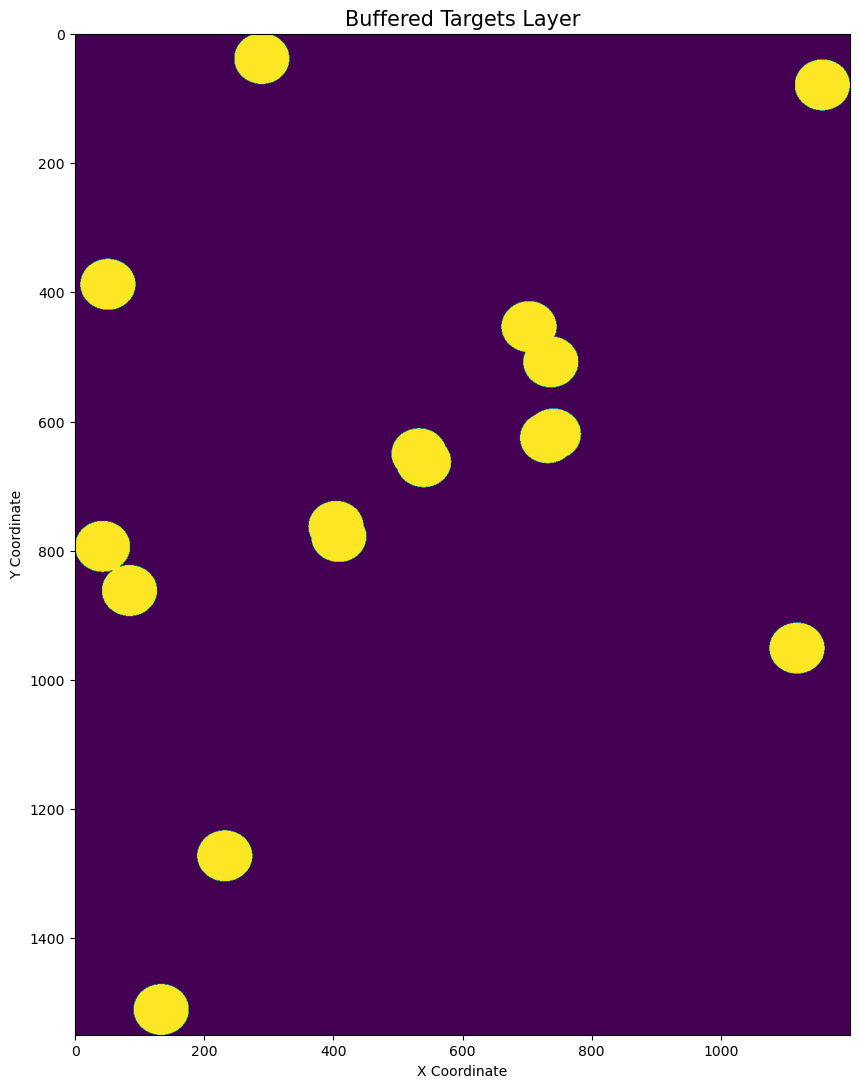

In [18]:
plt.figure(figsize=(10,14))
plt.imshow(combined_data[17])
plt.title("Buffered Targets Layer", fontsize=15)
plt.xlabel("X Coordinate", fontsize=10)
plt.ylabel("Y Coordinate", fontsize=10)

In [15]:
# CONVERT TO XARRAY

# Create dummy arrays for X, Y coordinates (you can replace these with your actual coordinates)
x_coords = np.arange(combined_data.shape[2])  # X-coordinates (along the third axis)
y_coords = np.arange(combined_data.shape[1])  # Y-coordinates (along the second axis)
layer_names = combined_layer_names  # Layer names

# Create an xarray DataArray from the combined NumPy array
data_xr = xr.DataArray(
    combined_data, 
    dims=["layer", "y", "x"], 
    coords={"layer": layer_names, "y": y_coords, "x": x_coords},
    name="combined_layers"
)


In [ ]:
# EXPORT DATA ////////// EXPORT XARRAY TO NETCDF

# Hide the root window for the file dialog
root = Tk()
root.withdraw()  # Hide the main window
root.attributes("-topmost", True)  # Bring the file dialog to the front

# Prompt the user to select a location to save the NetCDF file
output_file = asksaveasfilename(
    initialfile="THE_CUBE.nc",  # Default file name
    defaultextension=".nc",  # Default extension
    filetypes=[("NetCDF files", "*.nc"), ("All files", "*.*")],
    title="Save NetCDF file"
)

# If the user provides a location, save the NetCDF file
if output_file:
    data_xr.to_netcdf(output_file)
    print(f"Data successfully exported to {output_file}")

# Destroy the root window after file dialog is closed
root.destroy()

In [ ]:
print(np.unique(combined_data[15]))